In [44]:
file_path = 'summarization_dataset.csv'

In [45]:
!pip install transformers
!pip install datasets

## EDA

                                                  Article  \
count                                                 670   
unique                                                134   
top     كانت إيطاليا آخر الدول الأوروبية التي دخلت مجا...   
freq                                                    5   

                                                  Summary  
count                                                 670  
unique                                                627  
top      _طرح مدير مدرسة حبيب بن زيد الانصاري الابتدائ...  
freq                                                    3  
Article    0
Summary    0
dtype: int64


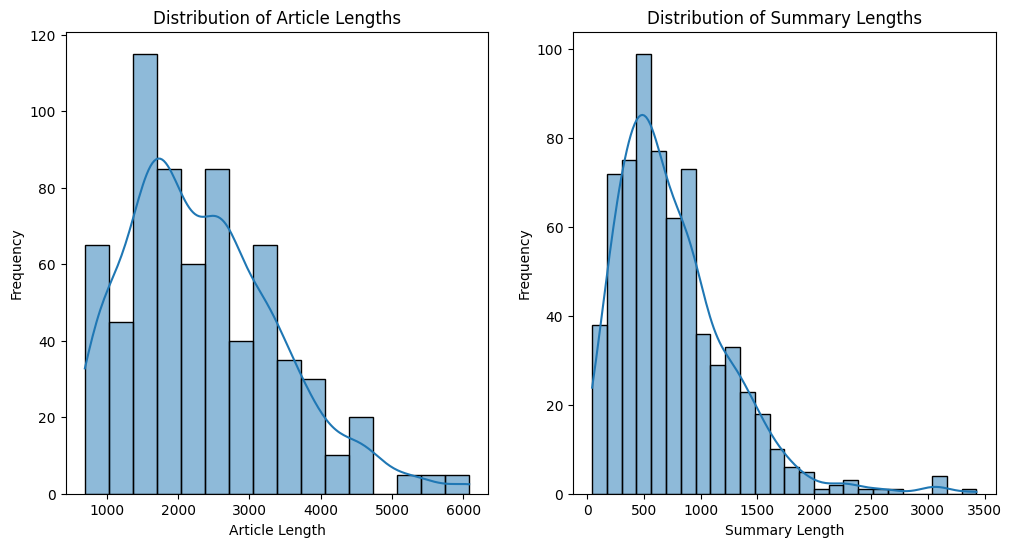

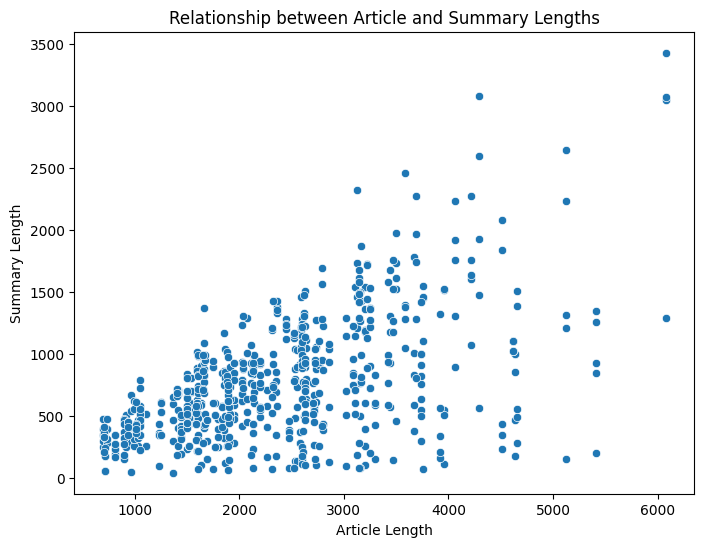

In [46]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('summarization_dataset.csv', sep='|')

# Display basic statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Analyze article and summary lengths
df['article_length'] = df['Article'].apply(len)
df['summary_length'] = df['Summary'].apply(len)

# Plot distributions of lengths
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['article_length'], kde=True)
plt.title('Distribution of Article Lengths')
plt.xlabel('Article Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['summary_length'], kde=True)
plt.title('Distribution of Summary Lengths')
plt.xlabel('Summary Length')
plt.ylabel('Frequency')
plt.show()

# Explore the relationship between article and summary lengths
plt.figure(figsize=(8, 6))
sns.scatterplot(x='article_length', y='summary_length', data=df)
plt.title('Relationship between Article and Summary Lengths')
plt.xlabel('Article Length')
plt.ylabel('Summary Length')
plt.show()


Article 0 Most common words:
[('في', 22), ('من', 13), ('بيتهوفن', 7), ('على', 7), ('عام', 5), ('أعماله', 5), ('فقد', 5), ('إلى', 5), ('الموسيقى', 4), ('أن', 4)]
Summary 0 Most common words:
[('في', 5), ('على', 2), ('انتاجه', 2), ('الى', 2), ('له', 1), ('الفضل', 1), ('الاعظم', 1), ('تطوير', 1), ('الموسيقى', 1), ('الكلاسيكية', 1)]
--------------------
Article 1 Most common words:
[('في', 22), ('من', 13), ('بيتهوفن', 7), ('على', 7), ('عام', 5), ('أعماله', 5), ('فقد', 5), ('إلى', 5), ('الموسيقى', 4), ('أن', 4)]
Summary 1 Most common words:
[('من', 7), ('في', 7), ('على', 5), ('بيتهوفن', 3), ('ان', 3), ('موسيقية', 2), ('البيانو', 2), ('عمره', 2), ('الا', 2), ('لم', 2)]
--------------------
Article 2 Most common words:
[('في', 22), ('من', 13), ('بيتهوفن', 7), ('على', 7), ('عام', 5), ('أعماله', 5), ('فقد', 5), ('إلى', 5), ('الموسيقى', 4), ('أن', 4)]
Summary 2 Most common words:
[('من', 2), ('الموسيقى', 2), ('في', 2), ('موسيقية', 2), ('على', 2), ('يعتبر', 1), ('ابرز', 1), ('عباقرة', 1), ('جميع'

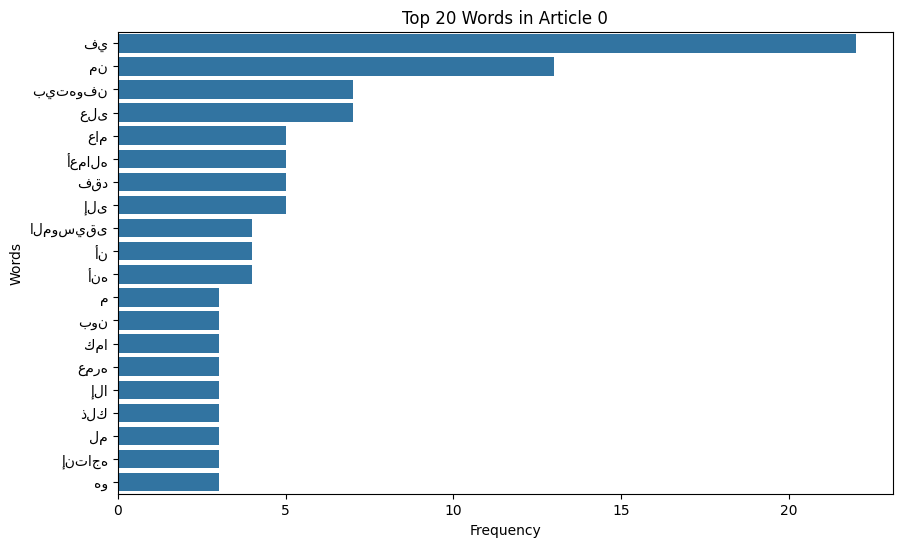

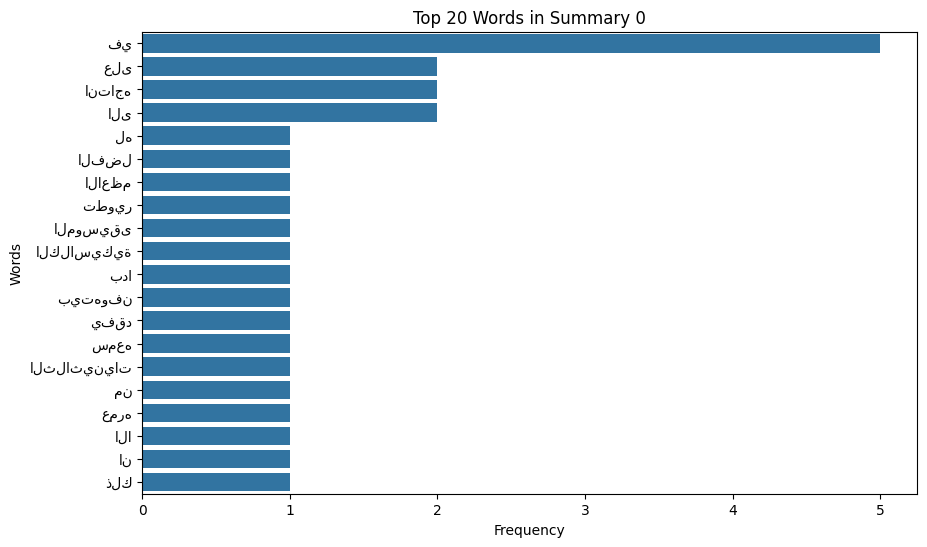

In [47]:

from collections import Counter

def word_frequency_analysis(text):
    """Analyzes word frequencies in a given text."""
    words = text.lower().split()
    # Remove punctuation and other non-alphanumeric characters
    words = [word.strip('.,!?"\'-') for word in words]
    word_counts = Counter(words)
    return word_counts

# Example usage (you would apply this to each article and summary)
# Assuming your DataFrame is named 'df'

df['article_word_counts'] = df['Article'].apply(word_frequency_analysis)
df['summary_word_counts'] = df['Summary'].apply(word_frequency_analysis)


# Print the most common words in an article and summary
for index, row in df.head(5).iterrows():
  print(f"Article {index} Most common words:")
  print(row['article_word_counts'].most_common(10)) # Prints the top 10 most frequent words
  print(f"Summary {index} Most common words:")
  print(row['summary_word_counts'].most_common(10))
  print("-"*20)


# Further analysis (example: plotting top 20 words)

def plot_top_words(word_counts, title):
    top_words = word_counts.most_common(20)
    words = [word for word, count in top_words]
    counts = [count for word, count in top_words]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=words)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Example for the first article
plot_top_words(df['article_word_counts'].iloc[0], "Top 20 Words in Article 0")
plot_top_words(df['summary_word_counts'].iloc[0], "Top 20 Words in Summary 0")

In [48]:
import torch
from torch.utils.data import Dataset

class SummarizationDataset(Dataset):
    def __init__(self, data, tokenizer, max_input_length=512, max_target_length=150):
        self.data = data
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        article = self.data.iloc[idx]['Article']
        summary = self.data.iloc[idx]['Summary']

        inputs = self.tokenizer(
            article,
            max_length=self.max_input_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        targets = self.tokenizer(
            summary,
            max_length=self.max_target_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        input_ids = inputs["input_ids"].squeeze()
        attention_mask = inputs["attention_mask"].squeeze()
        labels = targets["input_ids"].squeeze()
        # Ignore pad tokens for loss calculation
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        }

In [49]:
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/AraT5v2-base-1024")

# Example usage with your SummarizationDataset and DataLoader
dataset = SummarizationDataset(df, tokenizer)
batch_size = 3 # Example batch size; you might want to adjust this
shuffle = True
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Now you can iterate through the dataloader
for batch in dataloader:
    # Access the input_ids, attention_mask, and labels for each batch
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    print(f"Input IDs shape: {input_ids.shape}")
    print(f"Attention Mask shape: {attention_mask.shape}")
    print(f"Labels shape: {labels.shape}")
    # ... your training/evaluation loop ...
    break #remove this line if you actually want to process the whole dataloader

Input IDs shape: torch.Size([3, 512])
Attention Mask shape: torch.Size([3, 512])
Labels shape: torch.Size([3, 150])


## Finetuning

In [50]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("UBC-NLP/AraT5v2-base-1024")
model

T5ForConditionalGeneration(
  (shared): Embedding(110208, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(110208, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo

In [51]:
from transformers import T5ForConditionalGeneration

class CustomT5(T5ForConditionalGeneration):
    def freeze_layers(self):
        # Freeze all parameters by default
        for param in self.parameters():
            param.requires_grad = False

        # Unfreeze the later half of the encoder attention layers
        num_encoder_layers = len(self.encoder.block)
        for i in range(num_encoder_layers // 2, num_encoder_layers):
            for param in self.encoder.block[i].layer[0].parameters():  # layer[0] is the attention layer
                param.requires_grad = True

        # Unfreeze the later half of the decoder attention layers
        num_decoder_layers = len(self.decoder.block)
        for i in range(num_decoder_layers // 2, num_decoder_layers):
            for param in self.decoder.block[i].layer[0].parameters():  # layer[0] is the attention layer
                param.requires_grad = True

In [52]:
# Load your model using the custom class
model = CustomT5.from_pretrained("UBC-NLP/AraT5v2-base-1024")

# Freeze the layers before starting training
model.freeze_layers()

In [53]:

def parameter_status(model):
    """
    Checks which parameters of the model require gradients and returns a dictionary.
    """
    parameter_dict = {}
    for name, param in model.named_parameters():
        parameter_dict[name] = param.requires_grad
    return parameter_dict

# Get the parameter status dictionary for your model
param_status = parameter_status(model)

param_status

{'shared.weight': False,
 'encoder.block.0.layer.0.SelfAttention.q.weight': False,
 'encoder.block.0.layer.0.SelfAttention.k.weight': False,
 'encoder.block.0.layer.0.SelfAttention.v.weight': False,
 'encoder.block.0.layer.0.SelfAttention.o.weight': False,
 'encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight': False,
 'encoder.block.0.layer.0.layer_norm.weight': False,
 'encoder.block.0.layer.1.DenseReluDense.wi_0.weight': False,
 'encoder.block.0.layer.1.DenseReluDense.wi_1.weight': False,
 'encoder.block.0.layer.1.DenseReluDense.wo.weight': False,
 'encoder.block.0.layer.1.layer_norm.weight': False,
 'encoder.block.1.layer.0.SelfAttention.q.weight': False,
 'encoder.block.1.layer.0.SelfAttention.k.weight': False,
 'encoder.block.1.layer.0.SelfAttention.v.weight': False,
 'encoder.block.1.layer.0.SelfAttention.o.weight': False,
 'encoder.block.1.layer.0.layer_norm.weight': False,
 'encoder.block.1.layer.1.DenseReluDense.wi_0.weight': False,
 'encoder.block.1.layer.1.

In [54]:
! pip install torchmetrics

In [58]:

import pandas as pd
from torch.utils.data import DataLoader
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
import torchmetrics

df = pd.read_csv('summarization_dataset.csv', sep='|')
train_df, test_df = train_test_split(df, test_size=0.2, random_state=60)

# Update the dataset with the training data
dataset = SummarizationDataset(train_df, tokenizer)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyperparameters
epochs = 10 # (was actually done twice, as in 10 epochs, then finetune the already-finetuned model on 10 more epochs, so basically 20)
learning_rate = 5e-5
warmup_steps = 500
label_smoothing = 0.1 #label smoothing value

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Initialize ROUGE metric
rouge = torchmetrics.text.rouge.ROUGEScore(
    rouge_keys=("rouge1", "rouge2", "rougeL"),
    tokenizer=tokenizer,
).to(device)

# Loss function with label smoothing
loss_fct = CrossEntropyLoss(label_smoothing=label_smoothing)

history = []

# Training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0  # Accumulate loss for the epoch
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()

        print(f"Epoch: {epoch+1}/{epochs}, Loss: {loss.item()}")

        epoch_loss += loss.item()  # Add batch loss to epoch loss

    # Calculate average epoch loss
    avg_epoch_loss = epoch_loss / len(dataloader)

    # Append epoch loss to history
    history.append(avg_epoch_loss)

# Save the final model
model.save_pretrained(f"finetuned_model")


Epoch: 1/10, Loss: 8.822742462158203
Epoch: 1/10, Loss: 8.438634872436523
Epoch: 1/10, Loss: 9.145303726196289
Epoch: 1/10, Loss: 9.494466781616211
Epoch: 1/10, Loss: 8.555309295654297
Epoch: 1/10, Loss: 8.790779113769531
Epoch: 1/10, Loss: 9.108896255493164
Epoch: 1/10, Loss: 9.053828239440918
Epoch: 1/10, Loss: 9.185735702514648
Epoch: 1/10, Loss: 8.83469009399414
Epoch: 1/10, Loss: 8.782732009887695
Epoch: 1/10, Loss: 8.796441078186035
Epoch: 1/10, Loss: 9.224738121032715
Epoch: 1/10, Loss: 8.940362930297852
Epoch: 1/10, Loss: 9.145111083984375
Epoch: 1/10, Loss: 8.939048767089844
Epoch: 1/10, Loss: 8.849843978881836
Epoch: 1/10, Loss: 8.612861633300781
Epoch: 1/10, Loss: 8.971698760986328
Epoch: 1/10, Loss: 8.995645523071289
Epoch: 1/10, Loss: 9.066439628601074
Epoch: 1/10, Loss: 9.199758529663086
Epoch: 1/10, Loss: 8.707160949707031
Epoch: 1/10, Loss: 8.803827285766602
Epoch: 1/10, Loss: 8.699596405029297
Epoch: 1/10, Loss: 8.814981460571289
Epoch: 1/10, Loss: 8.274726867675781
Ep

In [ ]:
!pip install arabic-reshaper python-bidi pillow

In [ ]:
# prompt: plot history

import matplotlib.pyplot as plt

# Assuming 'history' is a list containing the average loss for each epoch
plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss History")
plt.show()

In [59]:
import arabic_reshaper
from bidi.algorithm import get_display

model.eval().to(device)
predictions = []
references = test_df['Summary'].tolist()

for index in range(len(test_df)):
    article = test_df.iloc[index]['Article']
    inputs = tokenizer(article, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        summary_ids = model.generate(**inputs, max_new_tokens=150)

    predicted_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Reshape predicted summary for correct Arabic display
    reshaped_summary = arabic_reshaper.reshape(predicted_summary)
    bidi_summary = get_display(reshaped_summary)

    predictions.append(bidi_summary)

# Calculate ROUGE
rouge_scores = rouge(predictions, references)  # Assuming one prediction and one reference for simplicity
print("ROUGE Scores:", rouge_scores)

# Calculate InfoLM values for predictions and references
# infolm_predictions = [calculate_infolm(text) for text in predictions]
# infolm_references = [calculate_infolm(text) for text in references]

# # Plot the InfoLM values
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.plot(infolm_predictions, label='Predictions')
# plt.plot(infolm_references, label='References')
# plt.xlabel('Text Index')
# plt.ylabel('InfoLM Value')
# plt.title('InfoLM Values for Predictions and References')
# plt.legend()
# plt.show()

ROUGE Scores: {'rouge1_fmeasure': tensor(1.), 'rouge1_precision': tensor(1.), 'rouge1_recall': tensor(1.), 'rouge2_fmeasure': tensor(1.), 'rouge2_precision': tensor(1.), 'rouge2_recall': tensor(1.), 'rougeL_fmeasure': tensor(1.), 'rougeL_precision': tensor(1.), 'rougeL_recall': tensor(1.)}


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

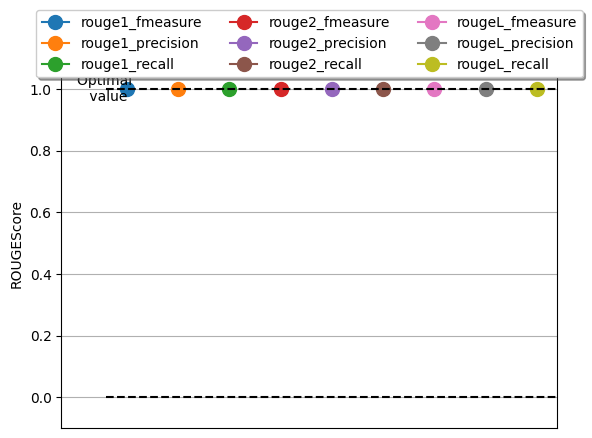

In [60]:
fig_, ax_ = rouge.plot()

In [62]:
# prompt: code to display a test article and summarize it while displaying the summary

import matplotlib.pyplot as plt
from transformers import pipeline

# Load the summarization pipeline
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Example text to summarize (replace with your desired article)
text = test_df.iloc[0]['Article'] # taking a random article from test set

# Generate the summary
summary = summarizer(text, max_length=150, min_length=30, do_sample=False)

# Display the original text and the summary
print("Original Text:")
print(text)
print("\nSummary:")
print(summary[0]["summary_text"])


# Display the ROUGE plot if needed
# fig_, ax_ = rouge.plot()  # Assuming 'rouge' is defined as in your original code
# plt.show()

Device set to use cuda:0
The model 'CustomT5' is not supported for summarization. Supported models are ['BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration', 'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'GPTSanJapaneseForConditionalGeneration', 'LEDForConditionalGeneration', 'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration', 'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'NllbMoeForConditionalGeneration', 'PegasusForConditionalGeneration', 'PegasusXForConditionalGeneration', 'PLBartForConditionalGeneration', 'ProphetNetForConditionalGeneration', 'Qwen2AudioForConditionalGeneration', 'SeamlessM4TForTextToText', 'SeamlessM4Tv2ForTextToText', 'SwitchTransformersForConditionalGeneration', 'T5ForConditionalGeneration', 'UMT5ForConditionalGeneration', 'XLMProphetNetForConditionalGeneration'].


Original Text:
الصراع العربي الإسرائيلي هو النزاع و التوترات السياسية التي نشأت بين دولة إسرائيل منذ بداية تشكلها عام 1948 و بقية الدول و الكيانات العربية المجاورة أو البعيدة عن إسرائيل . الخلاف يتركز أساسا حول أحقية اليهود في الاستيلاء على أرض فلسطين و إقامة دولتهم القومية على أرضها طاردين سكان فلسطين الموجودين فيها . أي أن طبيعة هذا النزاع تتركز أساسا حول ما يسمى النزاع الفلسطيني الإسرائيلي .
يطلق البعض على هذا النزاع اسم نزاع الشرق الأوسط ليشير إلى تركزه في منطقة الشرق الأوسط لكن هذا المصطلح غامض قليلا بسبب وجود عدة صراعات في منطقة الشرق الأوسط لكن النزاع العربي الإسرائيلي يبقى الأساسي و المركزي بينها . هذا الصراع يرتبط عضويا بموضوع النزاع الفلسطيني الإسرائيلي فقضيته المحورية و سببه الأساسي هو إقامة دولة قومية دينية لليهود على أرض فلسطين .يعتبر من قبل الكثير من المحلللين و السياسين العرب سبب أزمة هذه المنطقة و توترها .بالرغم من أن هذا الصراع يحدث ضمن منطقة جغرافية صغيرة نسبيا ، إلا انه يحظى باهتمام سياسي و إعلامي كبير نظرا لتورط العديد من الأطراف الدولية فيه و غالبا ما تكون الدول ال

## Implementing Differential Attention

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class RMSNorm(nn.Module):
    """
    Root Mean Square Layer Normalization.
    Applies normalization across the last dimension and scales the output.
    """
    def __init__(self, d, eps=1e-5):
        """
        Args:
            d (int): Dimension of the input features.
            eps (float): Small value to avoid division by zero.
        """
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(d))

    def forward(self, x):
        """
        Forward pass for RMSNorm.

        Args:
            x (Tensor): Input tensor of shape (batch, sequence_length, d).

        Returns:
            Tensor: Normalized and scaled tensor.
        """
        norm = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        return x / norm * self.scale

class SwiGLU(nn.Module):
    """
    SwiGLU Activation Function.
    Combines the Swish activation with Gated Linear Units.
    """
    def __init__(self, d_model):
        """
        Args:
            d_model (int): Dimension of the input features.
        """
        super().__init__()
        # Intermediate projection layers
        # Typically, SwiGLU splits the computation into two parts
        self.WG = nn.Linear(d_model, d_model * 2)
        self.W1 = nn.Linear(d_model, d_model * 2)
        self.W2 = nn.Linear(d_model * 2, d_model)

    def forward(self, x):
        """
        Forward pass for SwiGLU.

        Args:
            x (Tensor): Input tensor of shape (batch, sequence_length, d_model).

        Returns:
            Tensor: Output tensor after applying SwiGLU.
        """
        # Apply the gates
        g = F.silu(self.WG(x))  # Activation part
        z = self.W1(x)            # Linear part
        # Element-wise multiplication and projection
        return self.W2(g * z)

class MultiHeadDifferentialAttention(nn.Module):
    """
    Multi-Head Differential Attention Mechanism.
    Replaces the conventional softmax attention with a differential attention.
    Incorporates a causal mask to ensure autoregressive behavior.
    """
    def __init__(self, d_model, num_heads=2, lambda_init=0.1):
        """
        Args:
            d_model (int): Dimension of the model. Must be divisible by num_heads.
            num_heads (int): Number of attention heads.
            lambda_init (float): Initial value for lambda.
        """
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_head = d_model // num_heads

        # Linear projections for queries, keys, and values
        # Project to 2 * d_head per head for differential attention
        self.W_q = nn.Linear(d_model, 2 * self.d_head * num_heads, bias=False)
        self.W_k = nn.Linear(d_model, 2 * self.d_head * num_heads, bias=False)
        self.W_v = nn.Linear(d_model, 2 * self.d_head * num_heads, bias=False)
        self.W_o = nn.Linear(2 * self.d_head * num_heads, d_model, bias=False)

        # Learnable parameters for lambda reparameterization
        self.lambda_q1 = nn.Parameter(torch.randn(num_heads, self.d_head))
        self.lambda_k1 = nn.Parameter(torch.randn(num_heads, self.d_head))
        self.lambda_q2 = nn.Parameter(torch.randn(num_heads, self.d_head))
        self.lambda_k2 = nn.Parameter(torch.randn(num_heads, self.d_head))

        self.lambda_init = lambda_init

        # Scale parameter for RMSNorm
        self.rms_scale = nn.Parameter(torch.ones(2 * self.d_head))
        self.eps = 1e-5  # Epsilon for numerical stability

        # Initialize weights (optional but recommended)
        self._reset_parameters()

    def _reset_parameters(self):
        """
        Initialize parameters for improved training stability.
        """
        nn.init.xavier_uniform_(self.W_q.weight)
        nn.init.xavier_uniform_(self.W_k.weight)
        nn.init.xavier_uniform_(self.W_v.weight)
        nn.init.xavier_uniform_(self.W_o.weight)
        nn.init.constant_(self.rms_scale, 1.0)

    def forward(self, X, attention_mask=None, position_bias=None, **kwargs):
        """
        Forward pass for Multi-Head Differential Attention.

        Args:
            X (Tensor): Input tensor of shape (batch, sequence_length, d_model).

        Returns:
            Tensor: Output tensor after applying differential attention.
        """
        batch, N, d_model = X.shape

        # Project inputs to queries, keys, and values
        Q = self.W_q(X)  # Shape: (batch, N, 2 * num_heads * d_head)
        K = self.W_k(X)  # Shape: (batch, N, 2 * num_heads * d_head)
        V = self.W_v(X)  # Shape: (batch, N, 2 * num_heads * d_head)
                # Reshape and permute for multi-head attention
        # New shape: (batch, num_heads, sequence_length, 2 * d_head)
        Q = Q.view(batch, N, self.num_heads, 2 * self.d_head).transpose(1, 2)
        K = K.view(batch, N, self.num_heads, 2 * self.d_head).transpose(1, 2)
        V = V.view(batch, N, self.num_heads, 2 * self.d_head).transpose(1, 2)

        # Split Q and K into Q1, Q2 and K1, K2
        Q1, Q2 = Q.chunk(2, dim=-1)  # Each of shape: (batch, num_heads, N, d_head)
        K1, K2 = K.chunk(2, dim=-1)  # Each of shape: (batch, num_heads, N, d_head)

        # Compute lambda using reparameterization
        # lambda_val = exp(lambda_q1 . lambda_k1) - exp(lambda_q2 . lambda_k2) + lambda_init
        # Compute dot products for each head
        # Shape of lambda_val: (num_heads,)
        lambda_q1_dot_k1 = torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1).float()  # (num_heads,)
        lambda_q2_dot_k2 = torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1).float()  # (num_heads,)
        lambda_val = torch.exp(lambda_q1_dot_k1) - torch.exp(lambda_q2_dot_k2) + self.lambda_init  # (num_heads,)

        # Expand lambda_val to match attention dimensions
        # Shape: (batch, num_heads, 1, 1)
        lambda_val = lambda_val.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

        # ------------------- Causal Mask Implementation ------------------- #
        # Create a causal mask to prevent attention to future tokens
        # Shape of mask: (1, 1, N, N)
        mask = torch.tril(torch.ones((N, N), device=X.device)).unsqueeze(0).unsqueeze(0)  # (1, 1, N, N)
        # Replace 1s with 0.0 and 0s with -inf
        mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, 0.0)
        # -------------------------------------------------------------------- #

        # Compute attention scores
        scaling = 1 / math.sqrt(self.d_head)
        A1 = torch.matmul(Q1, K1.transpose(-2, -1)) * scaling  # (batch, num_heads, N, N)
        A2 = torch.matmul(Q2, K2.transpose(-2, -1)) * scaling  # (batch, num_heads, N, N)

        # Apply the causal mask
        A1 = A1 + mask  # Mask out future positions
        A2 = A2 + mask  # Mask out future positions

        # Apply softmax to get attention weights
        attention1 = F.softmax(A1, dim=-1)  # (batch, num_heads, N, N)
        attention2 = F.softmax(A2, dim=-1)  # (batch, num_heads, N, N)
        attention = attention1 - lambda_val * attention2  # (batch, num_heads, N, N)

        # Apply attention weights to values
        O = torch.matmul(attention, V)  # (batch, num_heads, N, 2 * d_head)

        # Normalize each head independently using RMSNorm
        # First, reshape for RMSNorm
        O_reshaped = O.contiguous().view(batch * self.num_heads, N, 2 * self.d_head)  # (batch*num_heads, N, 2*d_head)

        # Compute RMSNorm
        rms_norm = torch.sqrt(O_reshaped.pow(2).mean(dim=-1, keepdim=True) + self.eps)  # (batch*num_heads, N, 1)
        O_normalized = (O_reshaped / rms_norm) * self.rms_scale  # (batch*num_heads, N, 2*d_head)

        # Reshape back to (batch, num_heads, N, 2 * d_head)
        O_normalized = O_normalized.view(batch, self.num_heads, N, 2 * self.d_head)

        # Scale the normalized output
        O_normalized = O_normalized * (1 - self.lambda_init)  # Scalar scaling

        # Concatenate all heads
        # New shape: (batch, N, num_heads * 2 * d_head)
        O_concat = O_normalized.transpose(1, 2).contiguous().view(batch, N, self.num_heads * 2 * self.d_head)

        # Final linear projection
        out = self.W_o(O_concat)  # (batch, N, d_model)

        return out

## Finetuning Quasi-diff transformer

In [ ]:
from transformers import T5ForConditionalGeneration

class CustomT5DifferentialAttention(T5ForConditionalGeneration):

    def __init__(self, config):
        super().__init__(config)
        # Get the d_model from the config
        d_model = config.d_model
        # Replace the latter half of the decoder attention layers
        num_decoder_layers = len(self.decoder.block)
        for i in range(num_decoder_layers // 2, num_decoder_layers):
            # Pass d_model to MultiHeadDifferentialAttention
            self.decoder.block[-1] = MultiHeadDifferentialAttention(d_model=d_model)

    def freeze_layers(self):
        # Freeze all parameters by default
        for param in self.parameters():
            param.requires_grad = False

        # Unfreeze the later half of the encoder attention layers
        num_encoder_layers = len(self.encoder.block)
        for i in range(num_encoder_layers // 2, num_encoder_layers):
            for param in self.encoder.block[i].layer[0].parameters():  # layer[0] is the attention layer
                param.requires_grad = True

        # Unfreeze the later half of the decoder attention layers
        num_decoder_layers = len(self.decoder.block)
        for i in range(num_decoder_layers // 2, num_decoder_layers):
            for param in self.decoder.block[i].layer[0].parameters():  # layer[0] is the attention layer
                param.requires_grad = True

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch
from torch.nn import functional as F

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('aubmindlab/bert-base-arabertv2')
model_forinfolm = BertForMaskedLM.from_pretrained('aubmindlab/bert-base-arabertv2')
model_forinfolm.eval()  # Set the model to evaluation mode

def calculate_infolm(text):
    """Calculates InfoLM values for a given text."""

    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt")

    # Get the model's predictions for masked tokens
    with torch.no_grad():
        outputs = model(**inputs)

    # Calculate the probabilities of the original tokens
    probs = F.softmax(outputs.logits, dim=-1)
    original_probs = probs[0, torch.arange(0, inputs['input_ids'].shape[1]), inputs['input_ids'][0]]

    # Calculate the average negative log-likelihood (InfoLM value)
    infolm_value = -torch.mean(torch.log(original_probs))

    return infolm_value.item()

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from transformers import AutoTokenizer
import pandas as pd
from torch.utils.data import DataLoader
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
import torchmetrics

df = pd.read_csv('summarization_dataset.csv', sep='|')
train_df, test_df = train_test_split(df, test_size=0.2, random_state=60)
batch_size = 5
shuffle = True

tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/AraT5v2-base-1024")
# Update the dataset with the training data
dataset = SummarizationDataset(train_df, tokenizer)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


# Define the device (GPU if available, otherwise CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch_xla.core.xla_model as xm

device = xm.xla_device()
model = CustomT5DifferentialAttention.from_pretrained("UBC-NLP/AraT5v2-base-1024")
model.to(device)

# Hyperparameters
epochs = 10
learning_rate = 5e-5

warmup_steps = 500
label_smoothing = 0.1 #label smoothing value

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Initialize ROUGE metric
rouge = torchmetrics.text.rouge.ROUGEScore(
    rouge_keys=("rouge1", "rouge2", "rougeL"),
    tokenizer=tokenizer,
).to(device)

# Loss function with label smoothing
loss_fct = CrossEntropyLoss(label_smoothing=label_smoothing)


# Training loop
for epoch in range(epochs):
    model.train()
    para_loader = pl.ParallelLoader(dataloader, [device])
    for batch in para_loader:
        batch = batch[0]
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        xm.optimizer_step(optimizer)
        scheduler.step()

        print(f"Epoch: {epoch+1}/{epochs}, Loss: {loss.item()}")
        xm.mark_step()

    # Save the model (on the master core, if applicable)
    if xm.is_master_ordinal():
        model.save_pretrained(f"finetuned_model_tpu")



In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 12.6 MB/s eta 0:00:00


In [ ]:
# prompt: empty GPU ram even if used

import gc
import torch

gc.collect()
torch.cuda.empty_cache()